<a href="https://colab.research.google.com/github/anudeepk17/Yolov3/blob/master/tinyYolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/xslittlegrass/CarND-Vehicle-Detection

Cloning into 'CarND-Vehicle-Detection'...
remote: Enumerating objects: 64, done.
remote: Total 64 (delta 0), reused 0 (delta 0), pack-reused 64
Unpacking objects: 100% (64/64), done.


In [ ]:
!pip install q keras==1.2.2
!pip install tensorflow==1.2

In [ ]:
import os
os.chdir('/content/CarND-Vehicle-Detection')
import sys
sys.path.append('/content/CarND-Vehicle-Detection')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

import keras # broken for keras >= 2.0, use 1.2.2
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape


from utils import load_weights, Box, yolo_net_out_to_car_boxes, draw_box

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3989504/45929032 bytes (8.7%)8241152/45929032 bytes (17.9%)12533760/45929032 bytes (27.3%)16777216/45929032 bytes (36.5%)21086208/45929032 bytes (45.9%)25403392/45929032 bytes (55.3%)29696000/45929032 bytes (64.7%)33972224/45929032 bytes (74.0%)38371328/45929032 bytes (83.5%)42606592/45929032 bytes (92.8%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root/.imageio/ffmpeg/ffmpeg-linux64-v3.3.1.


Using TensorFlow backend.


In [ ]:
keras.backend.set_image_dim_ordering('th')



In [ ]:

model = Sequential()
model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(64,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(128,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(256,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(512,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1470))


In [ ]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 448, 448)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 16, 448, 448)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 224, 224)  0           leakyrelu_1[0][0]                
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 224, 224)  4640        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [ ]:
!wget https://pjreddie.com/media/files/yolo-tiny.weights

--2020-04-23 12:54:37--  https://pjreddie.com/media/files/yolo-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180357512 (172M) [application/octet-stream]
Saving to: ‘yolo-tiny.weights’

yolo-tiny.weights   100%[===================>] 172.00M   195KB/s    in 18m 26s 

2020-04-23 13:13:04 (159 KB/s) - ‘yolo-tiny.weights’ saved [180357512/180357512]



In [ ]:
load_weights(model,'/content/CarND-Vehicle-Detection/yolo-tiny.weights')

In [ ]:
imagePath = '/content/cars-parking-on-a-road-india-KMX704.jpg'
image = plt.imread(imagePath)
image_crop = image[300:650,500:,:]
resized = cv2.resize(image_crop,(448,448))

In [ ]:
batch = np.transpose(resized,(2,0,1))
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)
out = model.predict(batch)

In [ ]:
boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.17)

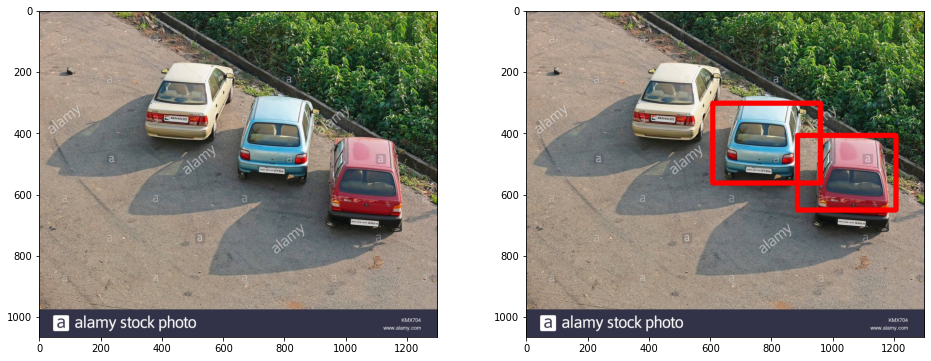

In [ ]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(image)
ax2.imshow(draw_box(boxes,plt.imread(imagePath),[[500,1280],[300,650]]))

In [ ]:
l=[0,3,[6,9]]
l2=l.copy()
l2[0]=8
print(l)
print(l2)

[0, 3, [6, 9]]
[8, 3, [6, 9]]


In [ ]:
def frame_func(image):
    crop = image[300:650,500:,:]
    resized = cv2.resize(crop,(448,448))
    batch = np.array([resized[:,:,0],resized[:,:,1],resized[:,:,2]])
    batch = 2*(batch/255.) - 1
    batch = np.expand_dims(batch, axis=0)
    out = model.predict(batch)
    boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.17)
    return draw_box(boxes,image,[[500,1280],[300,650]])

In [ ]:
project_video_output = '/content/CarND-Vehicle-Detection/project_videoout.mp4'
clip1 = VideoFileClip("/content/CarND-Vehicle-Detection/project_video.mp4")

In [ ]:
lane_clip = clip1.fl_image(frame_func) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video /content/CarND-Vehicle-Detection/project_videoout.mp4
[MoviePy] Writing video /content/CarND-Vehicle-Detection/project_videoout.mp4


100%|█████████▉| 1260/1261 [47:53<00:02,  2.28s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/CarND-Vehicle-Detection/project_videoout.mp4 

CPU times: user 1h 29min 6s, sys: 2min 8s, total: 1h 31min 14s
Wall time: 47min 56s


In [ ]:
def area(a,b):
  print('area is:')
  return a*b

area(2,3)

Hello


In [ ]:
a=13
print(id(a))

10914880


In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [ ]:
M_data = [[1., 2., 3.], [4., 5., 6]]
M = torch.tensor(M_data)
print(M)

tensor([[1., 2., 3.],
        [4., 5., 6.]])


In [ ]:
x = torch.randn(2, 3, 4)
print(x)
y=torch.tensor(x).transpose(0,2)
print(y)

tensor([[[ 0.2505, -0.7930,  0.5231,  1.2236],
         [-0.9458, -1.3529,  3.3837, -2.4044],
         [-0.5685,  0.8376,  1.7837, -0.1954]],

        [[ 0.5149, -1.8475, -2.9167, -0.5673],
         [-0.5413,  0.8952, -0.8825,  0.5318],
         [-1.5458, -0.1733,  0.7282,  0.0571]]])
tensor([[[ 0.2505,  0.5149],
         [-0.9458, -0.5413],
         [-0.5685, -1.5458]],

        [[-0.7930, -1.8475],
         [-1.3529,  0.8952],
         [ 0.8376, -0.1733]],

        [[ 0.5231, -2.9167],
         [ 3.3837, -0.8825],
         [ 1.7837,  0.7282]],

        [[ 1.2236, -0.5673],
         [-2.4044,  0.5318],
         [-0.1954,  0.0571]]])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
x = torch.randn(2, 3, 4)
print(x)
y=torch.tensor(x).transpose(1,2)
print(y)

tensor([[[ 0.9055,  1.0463, -0.5206,  1.3548],
         [ 0.2352,  1.9142,  1.8364,  1.3245],
         [ 2.6415, -0.9624, -0.2076, -1.3889]],

        [[ 0.0127, -1.8734,  1.7997,  0.2824],
         [ 1.6604,  0.2717, -0.8087,  0.1267],
         [ 0.5707, -0.1348,  0.3437,  0.3718]]])
tensor([[[ 0.9055,  0.2352,  2.6415],
         [ 1.0463,  1.9142, -0.9624],
         [-0.5206,  1.8364, -0.2076],
         [ 1.3548,  1.3245, -1.3889]],

        [[ 0.0127,  1.6604,  0.5707],
         [-1.8734,  0.2717, -0.1348],
         [ 1.7997, -0.8087,  0.3437],
         [ 0.2824,  0.1267,  0.3718]]])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
from collections import Counter

test_cases = int(input("Enter the number of Test Cases: "))
test_count = 0
tweet_names = []

while test_count < test_cases:

	num = int(input("Enter the number of each Test Case:"))
	count = 0
	while count < num:
		name = str(input("Enter the name followed by the Twitter ID (then press Enter): "))
		tweet_names.append(name)
		count += 1

	test_count += 1

uniq_names = [pref_names.split()[0] for pref_names in tweet_names]
times = Counter(uniq_names)
repeat = times.values()
for element in set(repeat):
	dupl = ([(key, value) for key, value in sorted(times.items()) if value == element])
  if len(dupl) > 1:
		for (key, value) in dupl:
			print (key,'',value)

	max_value = max(times.values())
	temp_max_result = [(key, value) for key, value in sorted(times.items()) if value == max_value]

	if temp_max_result != dupl:
		for (key,value) in temp_max_result:
			print (key,'',value)


Enter the number of Test Cases: 1
Enter the number of each Test Case:10
Enter the name followed by the Twitter ID (then press Enter): s
Enter the name followed by the Twitter ID (then press Enter): a
Enter the name followed by the Twitter ID (then press Enter): a
Enter the name followed by the Twitter ID (then press Enter): a
Enter the name followed by the Twitter ID (then press Enter): a
Enter the name followed by the Twitter ID (then press Enter): a
Enter the name followed by the Twitter ID (then press Enter): b
Enter the name followed by the Twitter ID (then press Enter): b
Enter the name followed by the Twitter ID (then press Enter): b
Enter the name followed by the Twitter ID (then press Enter): b


In [ ]:
temp_max_result = [(key, value) for key, value in sorted(times.items()) if value == max_value]

In [ ]:
temp_max_result

[('a', 5)]